<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Lab_5_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics

In [ ]:
import datetime
import random

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')
import math

# Importando libs de plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pal = sns.color_palette('rainbow')

## Generating datasets

In [ ]:
n_users = 5000

visit_user_ids = []
order_user_ids = []
visit_date_starts = []
visit_date_ends = []
order_timestamps = []
sales = []
sources = []
costs = []

np.random.seed(200)
random.seed(200)

num_months = 6
month_weights = np.random.uniform(size = num_months)

start_date = datetime.datetime(2021, 1, 1, 00, 00)
max_date = start_date + datetime.timedelta(days = 240)

def simulate_visit(time_seed, source):

  if source == "facebook":
    session_duration = round(10 * np.random.gamma(1.2, 1.5), 2)
    # session_duration = round(np.random.uniform(low=175, high=1200), 2)
    cost = round(np.random.uniform(low=200, high=300), 2)
  elif source == "tik-tok":
    session_duration = round(10 * np.random.gamma(1, 3), 2)
    # session_duration = round(np.random.uniform(low=55, high=750), 2)
    cost = round(np.random.uniform(low=150, high=250), 2)
  elif source == "google-ads":
    session_duration = round(10 * np.random.gamma(1.5, 6), 2)
    # session_duration = round(np.random.uniform(low=115, high=900), 2)
    cost = round(np.random.uniform(low=100, high=350), 2)

  # visit_random_range = np.random.uniform(low=10, high=150) / 10
  visit_random_range = (1 + np.random.uniform()) * np.random.gamma(1,3)
  visit_date_start = time_seed + datetime.timedelta(days=visit_random_range)
  visit_date_end = visit_date_start + datetime.timedelta(seconds=session_duration)

  return visit_date_start, visit_date_end, cost


def simulate_order_chance(source):

  if source == "facebook":
    order_made = np.random.uniform() > 0.7
  elif source == "tik-tok":
    order_made = np.random.uniform() > 0.4
  elif source == "google-ads":
    order_made = np.random.uniform() > 0.5

  return order_made


def simulate_order(visit_time, source):

  if source == "facebook":
    sale_timedelta = round(np.random.uniform(low=115, high=900), 2)
    sale = round(np.random.uniform(low=300, high=400), 2)
  elif source == "tik-tok":
    sale_timedelta = round(np.random.uniform(low=35, high=550), 2)
    sale = round(np.random.uniform(low=250, high=350), 2)
  elif source == "google-ads":
    sale_timedelta = round(np.random.uniform(low=55, high=750), 2)
    sale = round(np.random.uniform(low=200, high=500), 2)

  order_timestamp = visit_time + datetime.timedelta(seconds=sale_timedelta)

  return order_timestamp, sale


for i in range(n_users):
  month = random.choices(range(num_months), weights = month_weights)[0]
  random_range = (30 * month) + np.random.uniform(low=1, high=31)
  time_seed = start_date + datetime.timedelta(days=random_range)
  n_visits = int(np.abs(np.ceil(np.random.normal(5, 4))))
  # n_visits = int(np.random.uniform(low=1, high=10))

  source = random.choices(["facebook", "tik-tok", "google-ads"],  weights = [0.45, 0.35, 0.20])[0]

  # simulating visits, costs, orders
  for n in range(n_visits):

    visit_date_start, visit_date_end, cost = simulate_visit(time_seed, source)

    if visit_date_end >= max_date:
      continue

    order_chance = simulate_order_chance(source)

    if order_chance:
      order_timestamp, order_sale = simulate_order(visit_date_start, source)

      order_user_ids.append(i)
      order_timestamps.append(order_timestamp.strftime("%Y-%m-%d %H:%M:%S"))
      sales.append(order_sale)

    visit_user_ids.append(i)
    visit_date_starts.append(visit_date_start.strftime("%Y-%m-%d %H:%M:%S"))
    visit_date_ends.append(visit_date_end.strftime("%Y-%m-%d %H:%M:%S"))
    sources.append(source)
    costs.append(cost)

    time_seed = visit_date_end
    if time_seed >= max_date:
      break
    # new_time_seed = visit_date_end + datetime.timedelta(np.random.uniform(low = -150, high = 150) / 10)

    # if new_time_seed < start_date:
    #   new_time_seed = visit_date_end

    # time_seed = new_time_seed


visits_data = pd.DataFrame(data={
    "user_id": visit_user_ids,
    "start_timestamp": visit_date_starts,
    "end_timestamp": visit_date_ends,
    "source": sources,
    "cost": costs,
})
orders_data = pd.DataFrame(data={
    "user_id": order_user_ids,
    "timestamp": order_timestamps,
    "sale": sales,
})


visits_data["date"] = pd.to_datetime(visits_data["start_timestamp"]).dt.date
costs = visits_data.groupby(["date", "source"])["cost"].sum().reset_index()

visits_data.drop(columns=["cost", "date"], inplace=True)
costs_data = costs


visits_data = visits_data[pd.to_datetime(visits_data['end_timestamp']) <= start_date + datetime.timedelta(days=(num_months) * 30)]
costs_data = costs_data[pd.to_datetime(costs_data['date']) <= start_date + datetime.timedelta(days=(num_months) * 30)]
orders_data = orders_data[pd.to_datetime(orders_data['timestamp']) <= start_date + datetime.timedelta(days=(num_months) * 30)]

## Analysis


In [ ]:
orders_data.head()

,user_id,timestamp,sale
0,0,2021-01-25 14:17:20,345.01
1,3,2021-01-23 05:42:49,300.93
2,3,2021-01-27 02:35:38,372.31
3,3,2021-01-27 10:54:18,367.86
4,4,2021-01-28 01:39:11,316.85


In [ ]:
costs_data.head()

,date,source,cost
0,2021-01-02,google-ads,228.07
1,2021-01-02,tik-tok,765.07
2,2021-01-03,facebook,1450.41
3,2021-01-03,google-ads,581.24
4,2021-01-03,tik-tok,598.25


In [ ]:
visits_data.head()

,user_id,start_timestamp,end_timestamp,source,week,month,date,duration
0,0,2021-01-28 00:28:14,2021-01-28 00:28:43,facebook,2021-01-25/2021-01-31,2021-01,2021-01-28,29
1,0,2021-02-01 00:31:11,2021-02-01 00:31:17,facebook,2021-02-01/2021-02-07,2021-02,2021-02-01,6
2,0,2021-02-05 15:19:37,2021-02-05 15:20:04,facebook,2021-02-01/2021-02-07,2021-02,2021-02-05,27
3,0,2021-02-07 14:34:38,2021-02-07 14:34:41,facebook,2021-02-01/2021-02-07,2021-02,2021-02-07,3
4,0,2021-02-12 06:37:13,2021-02-12 06:37:51,facebook,2021-02-08/2021-02-14,2021-02,2021-02-12,38


### Preprocessing

In [ ]:
visits_data["start_timestamp"] = pd.to_datetime(visits_data["start_timestamp"])
visits_data["end_timestamp"] = pd.to_datetime(visits_data["end_timestamp"])
orders_data["timestamp"] = pd.to_datetime(orders_data["timestamp"])
costs_data["date"] = pd.to_datetime(costs_data["date"])


### Metrics

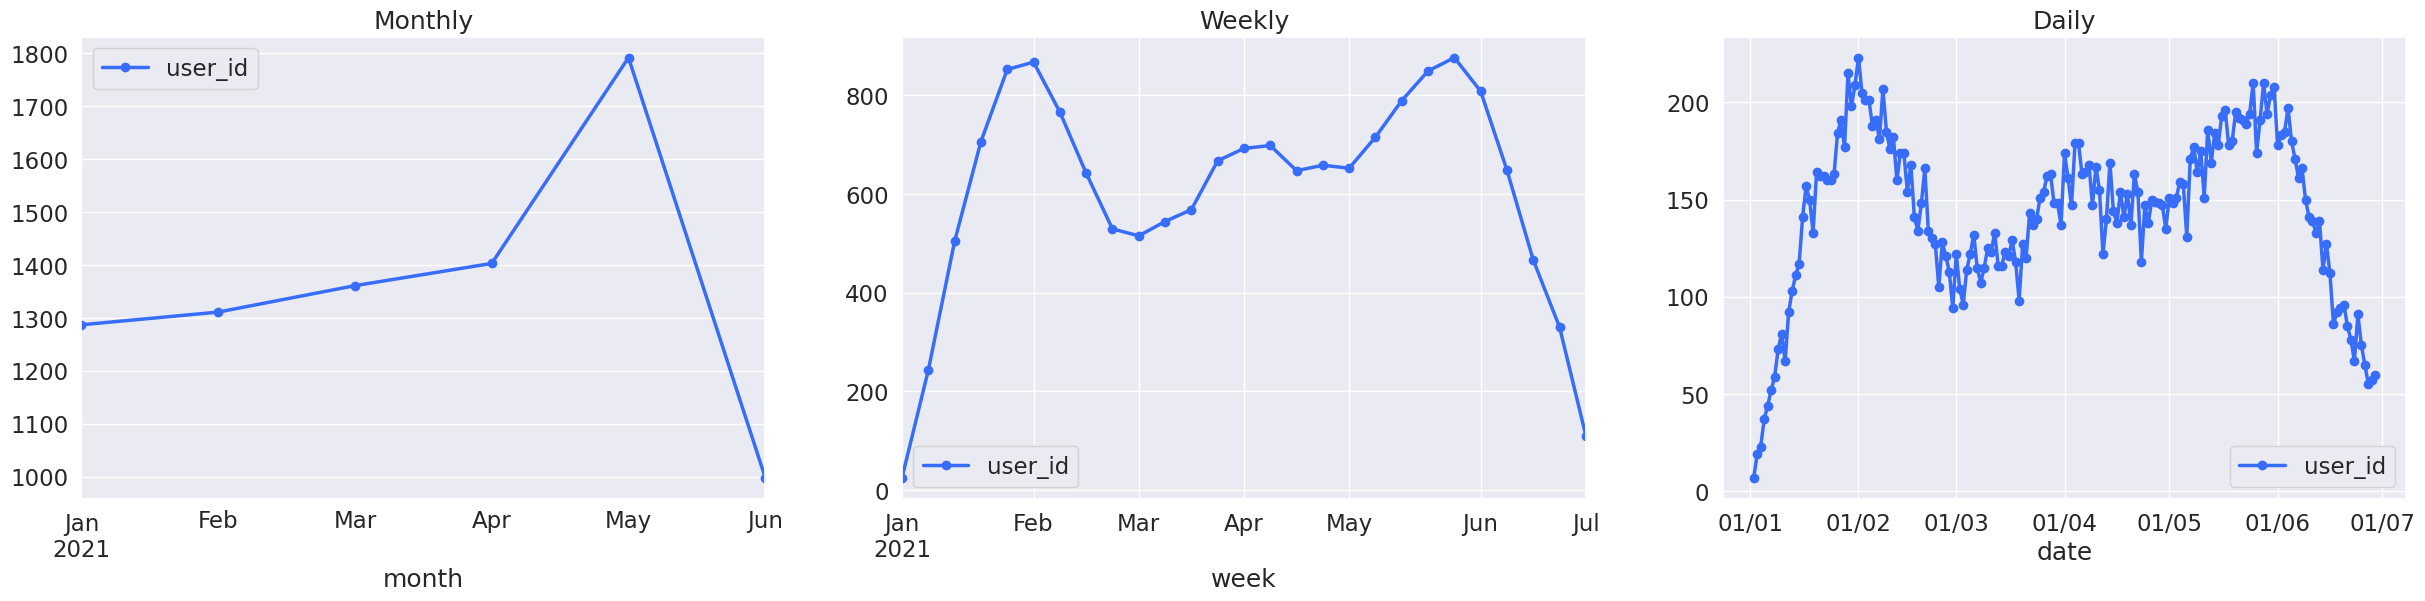

In [ ]:
visits_data["week"] = visits_data["start_timestamp"].dt.to_period('W')
visits_data["month"] = visits_data["start_timestamp"].dt.to_period('M')
visits_data["date"] = visits_data["start_timestamp"].dt.date

fig, ax  = plt.subplots(1, 3, figsize = (30, 6))

mau_data = visits_data.groupby("month").agg({"user_id": "nunique"})
mau_data.plot(ax = ax[0],  marker = 'o')
ax[0].set_title('Monthly')

weekly_sessions = visits_data.groupby("week").agg({"user_id": "nunique"})
weekly_sessions.plot(ax = ax[1], marker = 'o')
ax[1].set_title('Weekly')

daily_sessions = visits_data.groupby("date").agg({"user_id": "nunique"})
daily_sessions.plot(ax = ax[2], marker = 'o')
ax[2].set_title('Daily');

locator = mdates.AutoDateLocator(interval_multiples=True)
formatter = mdates.DateFormatter('%d/%m')

ax[2].xaxis.set_major_locator(locator)
ax[2].xaxis.set_major_formatter(formatter)

In [ ]:
sess_per_user = visits_data.groupby('date').agg({'user_id': ['count','nunique']})
sess_per_user.columns = ['n_sessions', 'n_users']
sess_per_user['sess_per_user'] = sess_per_user['n_sessions'] / sess_per_user['n_users']

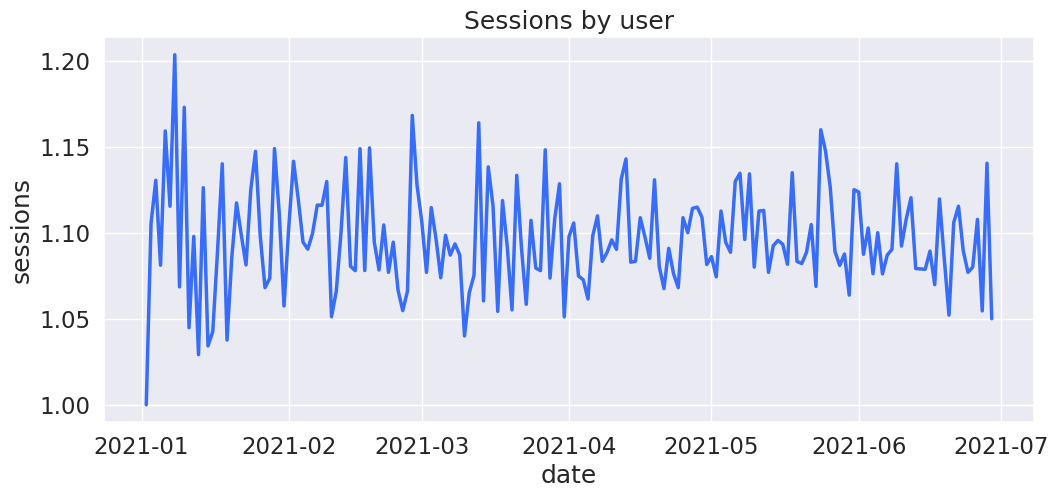

In [ ]:
plt.figure(figsize= (12,5))
sess_per_user['sess_per_user'].plot().set(title = 'Sessions by user', xlabel = 'date', ylabel = 'sessions');

In [ ]:
print('Average sessions per user is {} by day.'.format(round(sess_per_user['sess_per_user'].mean(),2)))

Average sessions per user is 1.1 by day.


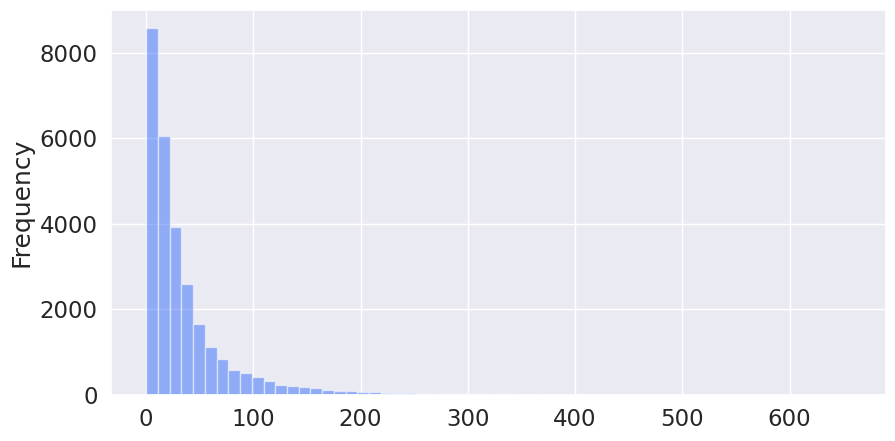

In [ ]:
visits_data["duration"] = (visits_data["end_timestamp"] - visits_data["start_timestamp"]).dt.seconds
visits_data["duration"].plot(kind="hist", figsize=(10, 5), bins=60, alpha=0.5)
plt.show()

#### Retention

In [ ]:
first_visits = visits_data.groupby("user_id").agg({"month": "min"}).reset_index().rename(columns={"month": "first_month"})
first_visits.head()

,user_id,first_month
0,0,2021-01
1,1,2021-04
2,3,2021-01
3,4,2021-01
4,5,2021-01


In [ ]:
visits_with_first_visit = visits_data.merge(first_visits, on="user_id", how="left")
visits_with_first_visit.head()

,user_id,start_timestamp,end_timestamp,source,week,month,date,duration,first_month
0,0,2021-01-28 00:28:14,2021-01-28 00:28:43,facebook,2021-01-25/2021-01-31,2021-01,2021-01-28,29,2021-01
1,0,2021-02-01 00:31:11,2021-02-01 00:31:17,facebook,2021-02-01/2021-02-07,2021-02,2021-02-01,6,2021-01
2,0,2021-02-05 15:19:37,2021-02-05 15:20:04,facebook,2021-02-01/2021-02-07,2021-02,2021-02-05,27,2021-01
3,0,2021-02-07 14:34:38,2021-02-07 14:34:41,facebook,2021-02-01/2021-02-07,2021-02,2021-02-07,3,2021-01
4,0,2021-02-12 06:37:13,2021-02-12 06:37:51,facebook,2021-02-08/2021-02-14,2021-02,2021-02-12,38,2021-01


In [ ]:
visits_with_first_visit["months_diff"] = visits_with_first_visit["month"].astype(int) - visits_with_first_visit["first_month"].astype(int)
visits_with_first_visit.head()

,user_id,start_timestamp,end_timestamp,source,week,month,date,duration,first_month,months_diff
0,0,2021-01-28 00:28:14,2021-01-28 00:28:43,facebook,2021-01-25/2021-01-31,2021-01,2021-01-28,29,2021-01,0
1,0,2021-02-01 00:31:11,2021-02-01 00:31:17,facebook,2021-02-01/2021-02-07,2021-02,2021-02-01,6,2021-01,1
2,0,2021-02-05 15:19:37,2021-02-05 15:20:04,facebook,2021-02-01/2021-02-07,2021-02,2021-02-05,27,2021-01,1
3,0,2021-02-07 14:34:38,2021-02-07 14:34:41,facebook,2021-02-01/2021-02-07,2021-02,2021-02-07,3,2021-01,1
4,0,2021-02-12 06:37:13,2021-02-12 06:37:51,facebook,2021-02-08/2021-02-14,2021-02,2021-02-12,38,2021-01,1


In [ ]:
retention_table = visits_with_first_visit.pivot_table(
    index="first_month",
    columns="months_diff",
    values="user_id",
    aggfunc="nunique"
)
retention_table.fillna("")

months_diff,0,1,2,3,4
first_month,,,,,
2021-01,1287.0,810.0,215.0,20.0,3.0
2021-02,501.0,268.0,53.0,4.0,
2021-03,878.0,558.0,135.0,4.0,
2021-04,772.0,458.0,86.0,,
2021-05,1192.0,733.0,,,
2021-06,175.0,,,,


In [ ]:
retention_rates = retention_table.copy()
for col in retention_rates.columns[1:]:
  retention_rates[col] = retention_rates[col] / retention_rates[0]

retention_rates[0] = retention_rates[0]/retention_rates[0]

retention_rates.fillna("")

months_diff,0,1,2,3,4
first_month,,,,,
2021-01,1.0,0.629371,0.167055,0.01554,0.002331
2021-02,1.0,0.53493,0.105788,0.007984,
2021-03,1.0,0.635535,0.153759,0.004556,
2021-04,1.0,0.593264,0.111399,,
2021-05,1.0,0.614933,,,
2021-06,1.0,,,,


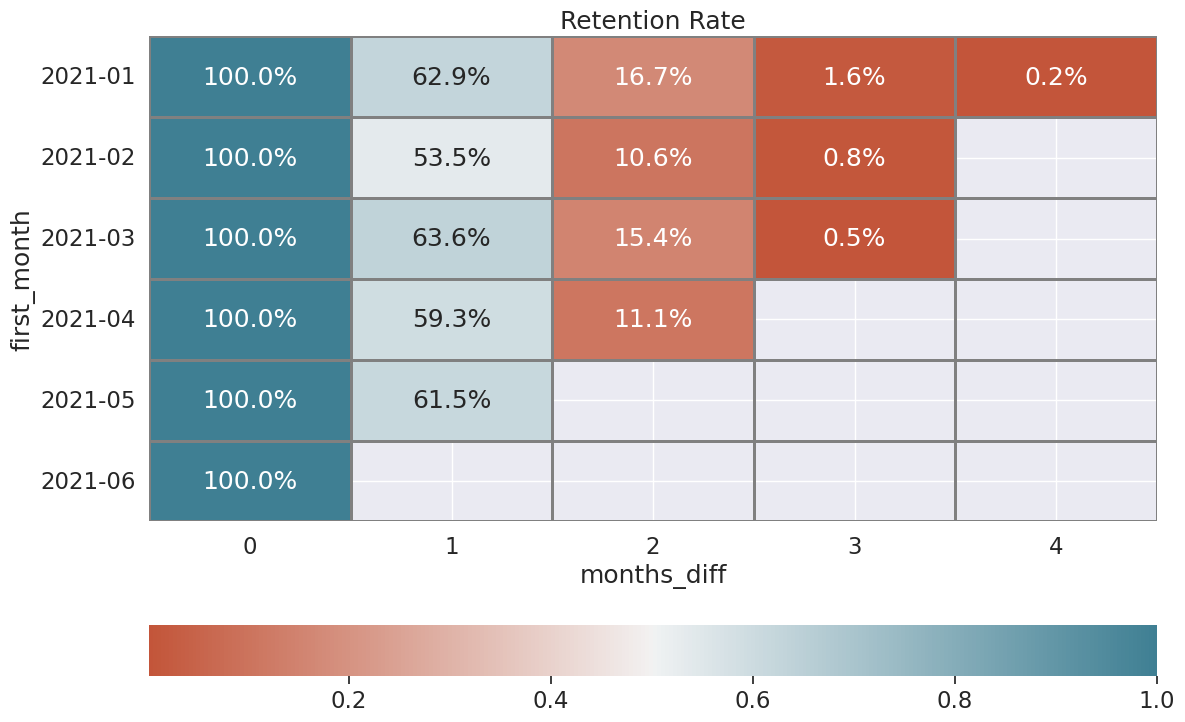

In [ ]:
plt.figure(figsize=(13, 9))
sns.heatmap(retention_rates, annot=True, fmt='.1%', linewidths=1, linecolor='grey', center = 0.5, vmax=1.0, cmap=sns.diverging_palette(20, 220, as_cmap=True), cbar_kws= {'orientation': 'horizontal'}).set(title = 'Retention Rate')
plt.show()

#### Sales

In [ ]:
orders_data.head()

,user_id,timestamp,sale
0,0,2021-02-01 00:40:40,345.01
1,3,2021-01-29 05:19:12,300.93
2,3,2021-02-04 00:34:09,372.31
3,3,2021-02-04 13:03:16,367.86
4,4,2021-01-28 19:31:08,316.85


In [ ]:
first_orders_data = orders_data.groupby("user_id").agg({"timestamp": "min"}).reset_index().rename(columns={"timestamp": "first_purchase"})
first_orders_data.head()

,user_id,first_purchase
0,0,2021-02-01 00:40:40
1,3,2021-01-29 05:19:12
2,4,2021-01-28 19:31:08
3,5,2021-01-27 10:24:01
4,6,2021-02-15 21:28:29


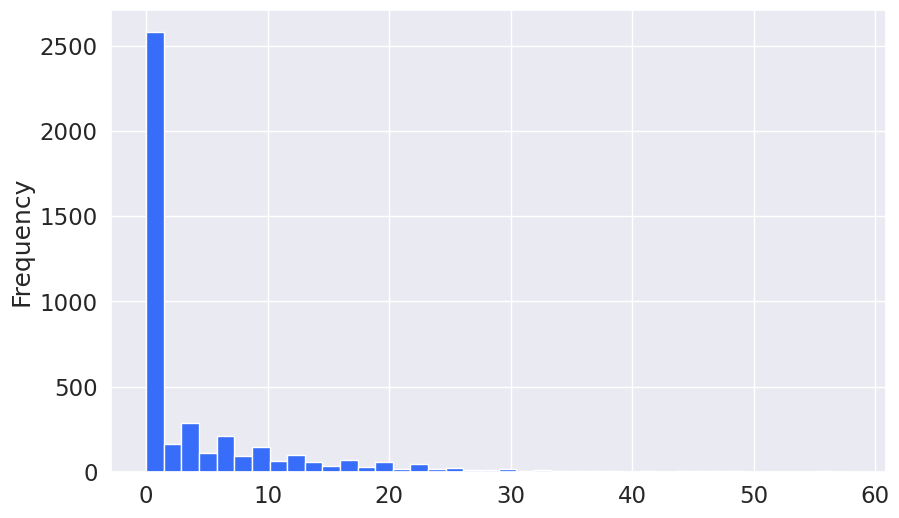

In [ ]:
first_visits_timestamp = visits_data.groupby("user_id").agg({"start_timestamp": "min"}).reset_index().rename(columns={"start_timestamp": "first_visit"})

first_visits_with_first_purchase = first_visits_timestamp.merge(first_orders_data, on="user_id", how="left")
first_visits_with_first_purchase = first_visits_with_first_purchase.dropna()

first_visits_with_first_purchase["time_to_first_purchase"] = first_visits_with_first_purchase["first_purchase"] - first_visits_with_first_purchase["first_visit"]
first_visits_with_first_purchase["time_to_first_purchase"] = first_visits_with_first_purchase["time_to_first_purchase"].dt.days

first_visits_with_first_purchase["time_to_first_purchase"].plot(kind="hist", figsize=(10, 6), bins=40)
plt.show()

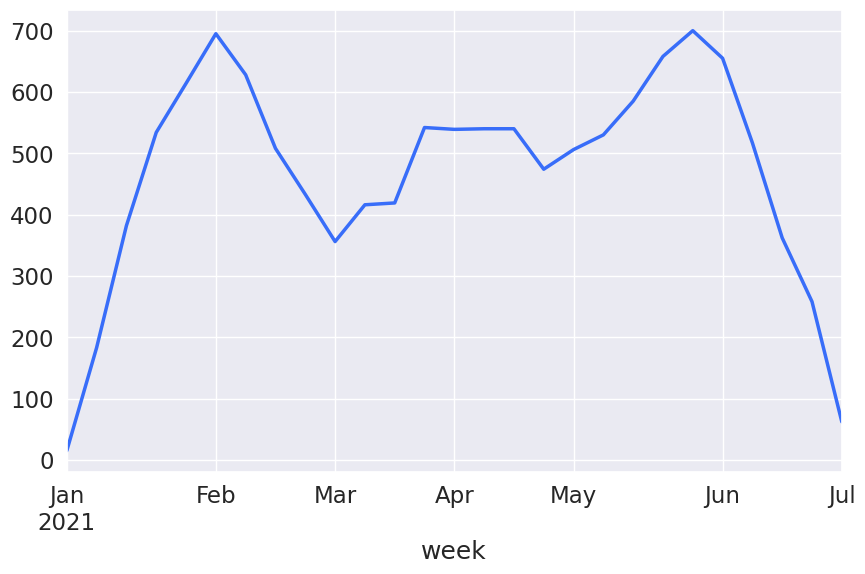

In [ ]:
orders_data["week"] = orders_data["timestamp"].dt.to_period('W')
weekly_orders_data = orders_data.groupby("week")["user_id"].count()

plt.figure(figsize=(10, 6))
weekly_orders_data.plot(kind="line")
plt.show()

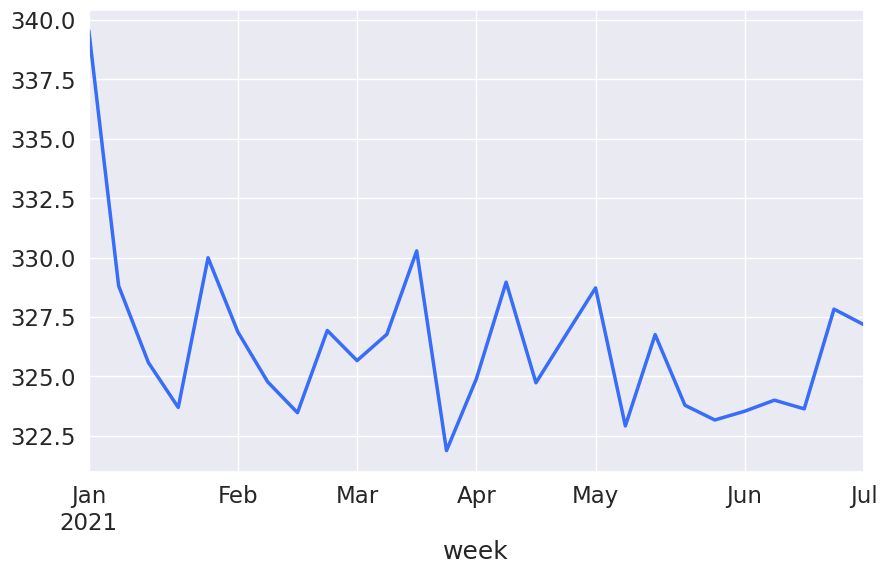

In [ ]:
avg_weekly_orders = orders_data.groupby("week").agg({"user_id": "count", "sale": "sum"})
avg_weekly_orders["avg_sale"] = avg_weekly_orders["sale"] / avg_weekly_orders["user_id"]

avg_weekly_orders["avg_sale"].plot(kind="line", figsize=(10, 6))
plt.show()

In [ ]:
orders_data["month"] = orders_data["timestamp"].dt.to_period('M')
orders_data.head()

,user_id,timestamp,sale,week,month
0,0,2021-02-01 00:40:40,345.01,2021-02-01/2021-02-07,2021-02
1,3,2021-01-29 05:19:12,300.93,2021-01-25/2021-01-31,2021-01
2,3,2021-02-04 00:34:09,372.31,2021-02-01/2021-02-07,2021-02
3,3,2021-02-04 13:03:16,367.86,2021-02-01/2021-02-07,2021-02
4,4,2021-01-28 19:31:08,316.85,2021-01-25/2021-01-31,2021-01


In [ ]:
first_visits_orders = first_visits.merge(orders_data, on="user_id", how="left")
first_visits_orders = first_visits_orders.dropna()

first_visits_orders["months_diff"] = (first_visits_orders["month"].astype(int) - first_visits_orders["first_month"].astype(int))

first_visits_orders.head()

,user_id,first_month,timestamp,sale,week,month,months_diff
0,0,2021-01,2021-02-01 00:40:40,345.01,2021-02-01/2021-02-07,2021-02,1
2,3,2021-01,2021-01-29 05:19:12,300.93,2021-01-25/2021-01-31,2021-01,0
3,3,2021-01,2021-02-04 00:34:09,372.31,2021-02-01/2021-02-07,2021-02,1
4,3,2021-01,2021-02-04 13:03:16,367.86,2021-02-01/2021-02-07,2021-02,1
5,4,2021-01,2021-01-28 19:31:08,316.85,2021-01-25/2021-01-31,2021-01,0


In [ ]:
purchase_by_user_by_month = first_visits_orders.groupby(["user_id", "first_month", "months_diff"]).agg({"sale": "sum"}).rename(columns={"sale": "customer_sale"}).reset_index()
purchase_by_user_by_month.sort_values(by=["user_id", "months_diff"]).head()

,user_id,first_month,months_diff,customer_sale
0,0,2021-01,1,345.01
1,3,2021-01,0,300.93
2,3,2021-01,1,740.17
3,4,2021-01,0,316.85
4,5,2021-01,0,304.31


In [ ]:
purchase_by_month_by_user = purchase_by_user_by_month.pivot_table(
    index="first_month",
    columns="months_diff",
    values="customer_sale",
    aggfunc="mean"
)

In [ ]:
purchase_by_month_by_user

months_diff,0,1,2,3,4
first_month,,,,,
2021-01,610.931330,683.700199,568.573667,546.445833,292.55
2021-02,724.506816,660.772806,582.592941,311.600000,NaN
2021-03,644.047154,719.587694,586.277128,413.785000,NaN
2021-04,661.394835,742.477493,541.912698,NaN,NaN
2021-05,642.890179,681.428003,NaN,NaN,NaN
2021-06,859.501250,NaN,NaN,NaN,NaN


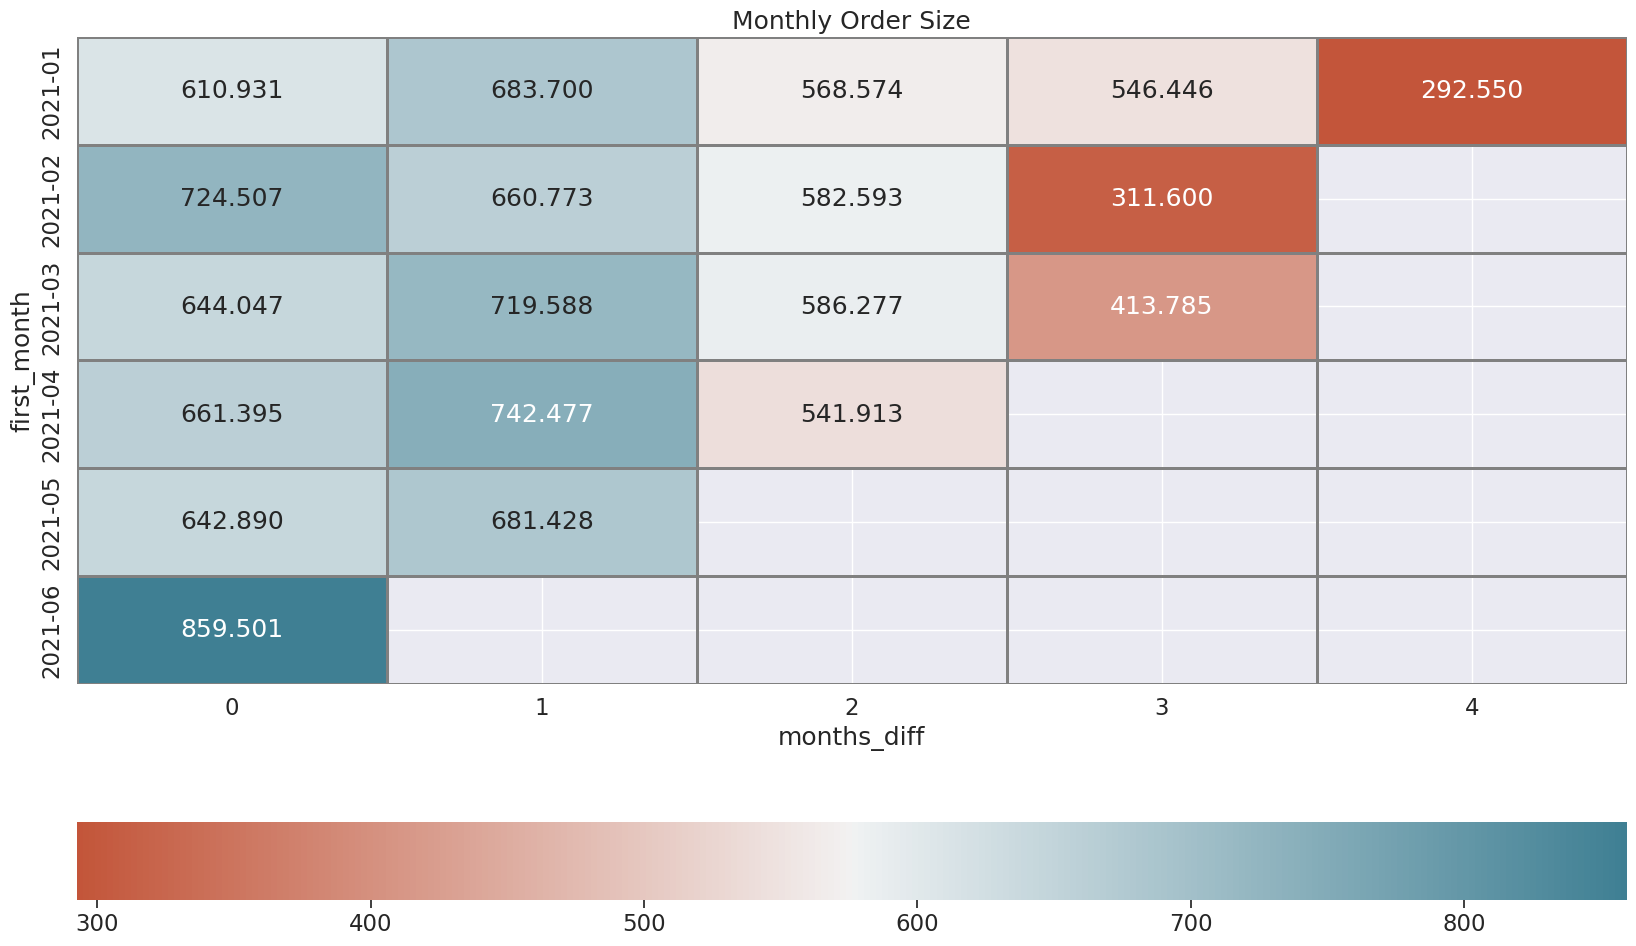

In [ ]:
fig, ax = plt.subplots(figsize = (20,12))
purchase_by_month_by_user.index= purchase_by_month_by_user.index.astype(str)
sns.heatmap(purchase_by_month_by_user, annot=True, fmt='.3f', linewidths=1, linecolor='grey', cmap=sns.diverging_palette(20, 220, as_cmap=True), cbar_kws={'orientation':'horizontal'}).set(title = "Monthly Order Size")

plt.show()

In [ ]:
purchase_retention = purchase_by_month_by_user.copy()
for col in purchase_retention.columns[1:]:
  purchase_retention[col] = purchase_retention[col] / purchase_retention[0]

purchase_retention[0] = purchase_retention[0]/purchase_retention[0]

purchase_retention.fillna("")

months_diff,0,1,2,3,4
first_month,,,,,
2021-01,1.0,1.119111,0.930667,0.894447,0.478859
2021-02,1.0,0.912031,0.804123,0.430086,
2021-03,1.0,1.11729,0.910302,0.642476,
2021-04,1.0,1.122593,0.819348,,
2021-05,1.0,1.059945,,,
2021-06,1.0,,,,


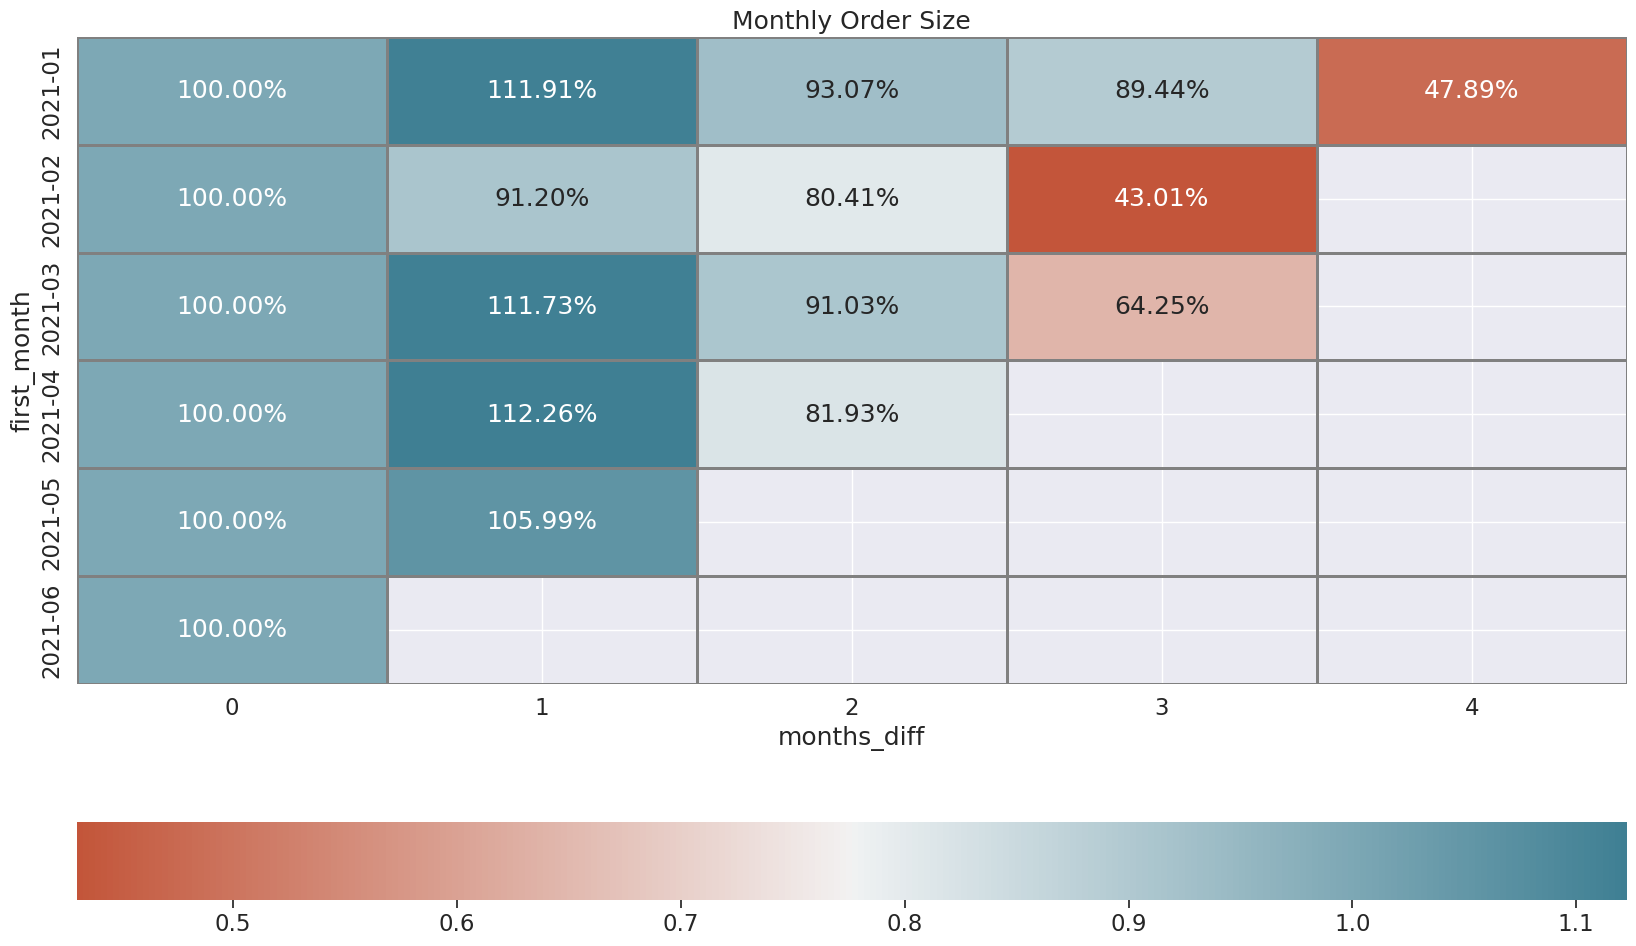

In [ ]:
fig, ax = plt.subplots(figsize = (20,12))
purchase_by_month_by_user.index= purchase_by_month_by_user.index.astype(str)
sns.heatmap(purchase_retention, annot=True, fmt='.2%', linewidths=1, linecolor='grey', cmap=sns.diverging_palette(20, 220, as_cmap=True), cbar_kws={'orientation':'horizontal'}).set(title = "Monthly Order Size")
plt.show()

#### LTV (Lifetime Value)

It's the total volume per user in his lifetime.

It can be usually estimated using

$$ \frac{\text{Margin}}{\text{Churn Rate}}$$


In [ ]:
first_visits_orders

,user_id,first_month,timestamp,sale,week,month,months_diff
0,0,2021-01,2021-02-01 00:40:40,345.01,2021-02-01/2021-02-07,2021-02,1
2,3,2021-01,2021-01-29 05:19:12,300.93,2021-01-25/2021-01-31,2021-01,0
3,3,2021-01,2021-02-04 00:34:09,372.31,2021-02-01/2021-02-07,2021-02,1
4,3,2021-01,2021-02-04 13:03:16,367.86,2021-02-01/2021-02-07,2021-02,1
5,4,2021-01,2021-01-28 19:31:08,316.85,2021-01-25/2021-01-31,2021-01,0
...,...,...,...,...,...,...,...
13262,4998,2021-04,2021-04-30 21:07:26,301.89,2021-04-26/2021-05-02,2021-04,0
13263,4998,2021-04,2021-05-02 02:51:23,348.83,2021-04-26/2021-05-02,2021-05,1
13264,4999,2021-05,2021-06-06 06:57:45,370.71,2021-05-31/2021-06-06,2021-06,1
13265,4999,2021-05,2021-06-15 01:04:28,318.18,2021-06-14/2021-06-20,2021-06,1


In [ ]:
first_orders_data['first_purchase_month'] = first_orders_data['first_purchase'].dt.to_period("M")
cohort_sizes = first_orders_data.groupby('first_purchase_month')['user_id'].nunique().reset_index().rename(columns = {'user_id' : 'n_buyers', 'first_purchase_month' : 'first_month'})

cohort = pd.merge(first_visits_orders, right = cohort_sizes, on = 'first_month')
cohort['LTV'] = cohort['sale'] / cohort['n_buyers']

In [ ]:
cohorts_ltv = cohort.pivot_table(
    index='first_month',
    columns='months_diff',
    values='LTV',
    aggfunc='sum'
).cumsum(axis=1)

cohorts_ltv.round(2).fillna('')

months_diff,0,1,2,3,4
first_month,,,,,
2021-01,610.93,1092.85,1185.05,1192.14,1192.77
2021-02,492.81,711.95,745.47,747.05,
2021-03,605.83,1075.49,1155.25,1157.64,
2021-04,552.76,922.92,972.55,,
2021-05,586.53,993.58,,,
2021-06,417.39,,,,


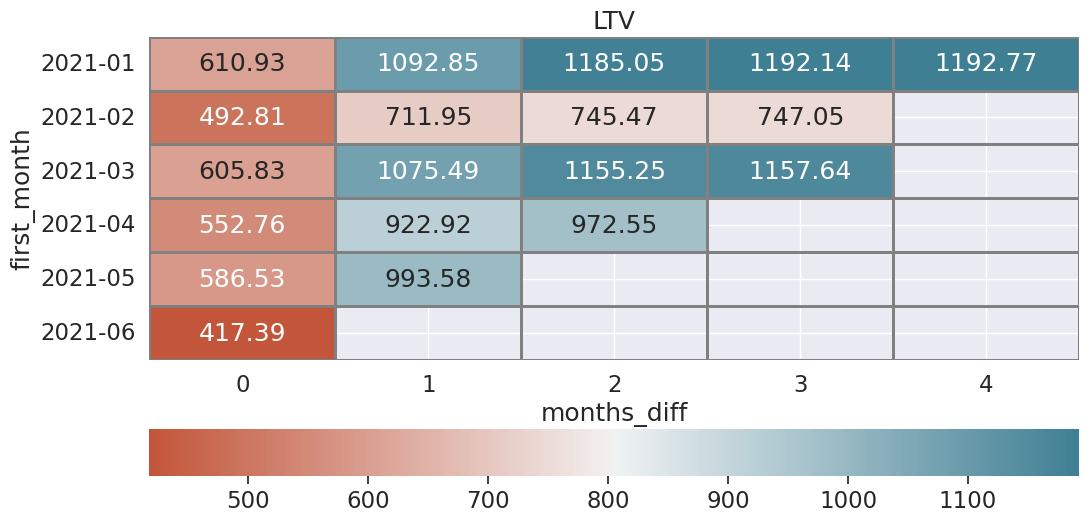

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
cohorts_ltv.index=cohorts_ltv.index.astype(str)
sns.heatmap(cohorts_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='grey',  cmap=sns.diverging_palette(20, 220, as_cmap=True), cbar_kws= {'orientation': 'horizontal'}
            ).set(title ='LTV')
plt.show()

In [ ]:
print("Average LTV in 3 months is:", round(cohorts_ltv[2].mean(),2))

Average LTV in 3 months is: 1014.58


In [ ]:
(cohort.query('months_diff < 3').groupby("first_month")['LTV'].sum() / (1 - retention_rates[2])).reset_index().rename(columns = {0 : 'Estimated LTV', 'first_month' : 'Cohort'})

,Cohort,Estimated LTV
0,2021-01,1422.721730
1,2021-02,833.659114
2,2021-03,1365.148975
3,2021-04,1094.469759
4,2021-05,NaN
5,2021-06,NaN


#### CAC (Customer Acquisition Cost)

$$ \frac{\text{Total Spent in Marketing and Sales}}{\text{Number of Acquired Customers}}$$

In [ ]:
costs_data.head()

,date,source,cost
0,2021-01-02,facebook,1246.36
1,2021-01-02,google-ads,361.82
2,2021-01-03,facebook,2024.65
3,2021-01-03,google-ads,976.34
4,2021-01-03,tik-tok,1725.95


In [ ]:
print('Total costs {}'.format(costs_data['cost'].sum()))

Total costs 6408339.609999999


In [ ]:
costs_data['costs_month'] = costs_data['date'].dt.to_period('M')

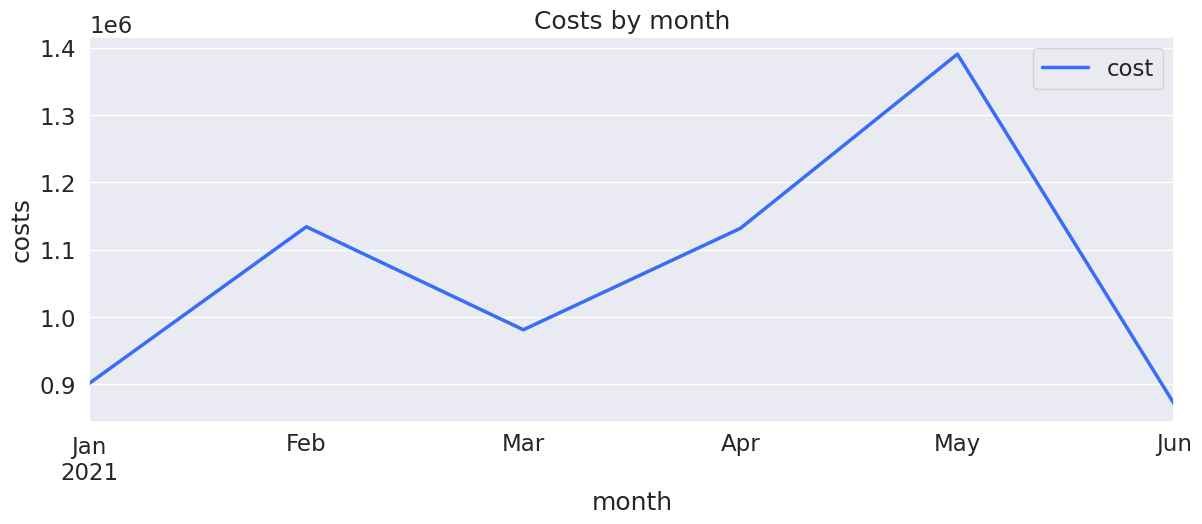

In [ ]:
(costs_data.pivot_table(index='costs_month', values='cost', aggfunc='sum')
      .plot(figsize=(14,5), title='Costs by month', xlabel = 'month', ylabel = 'costs'))
plt.show()

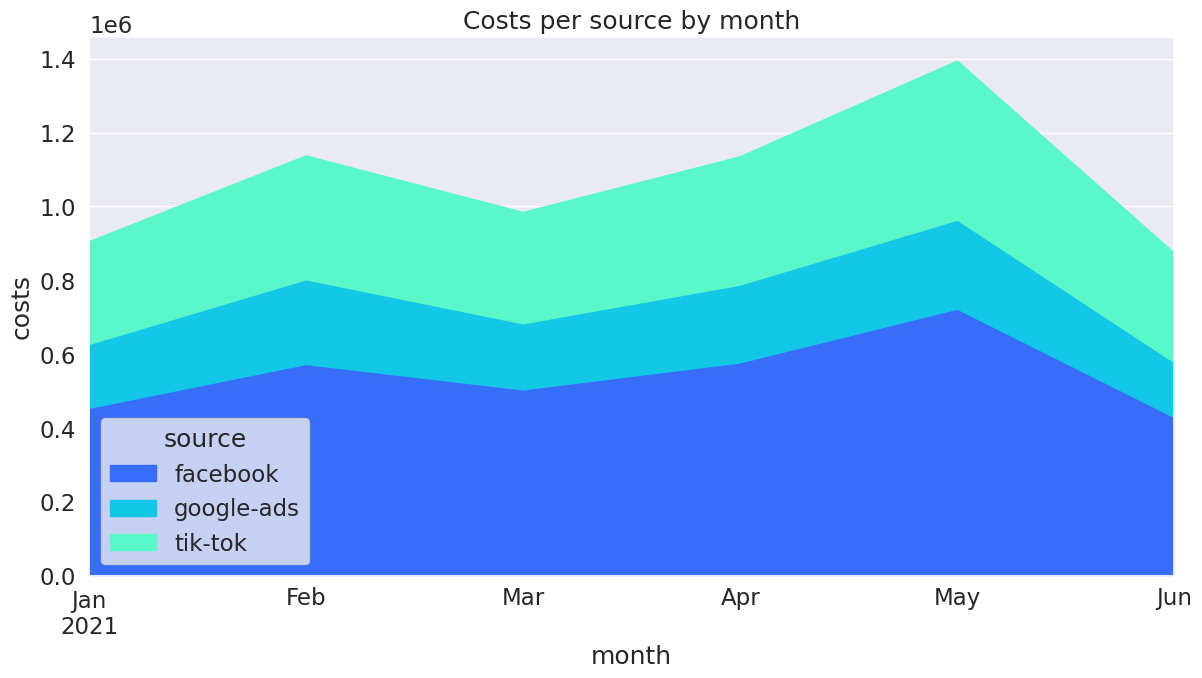

In [ ]:
(costs_data.pivot_table(index='costs_month', columns='source', values='cost', aggfunc='sum')
      .plot
      .area(figsize=(14,7), title='Costs per source by month', xlabel = 'month', ylabel = 'costs'))
plt.show()

In [ ]:
print("Mean CAC is:", round(costs_data['cost'].sum() / orders_data['user_id'].nunique(), 2))

Mean CAC is: 1529.8


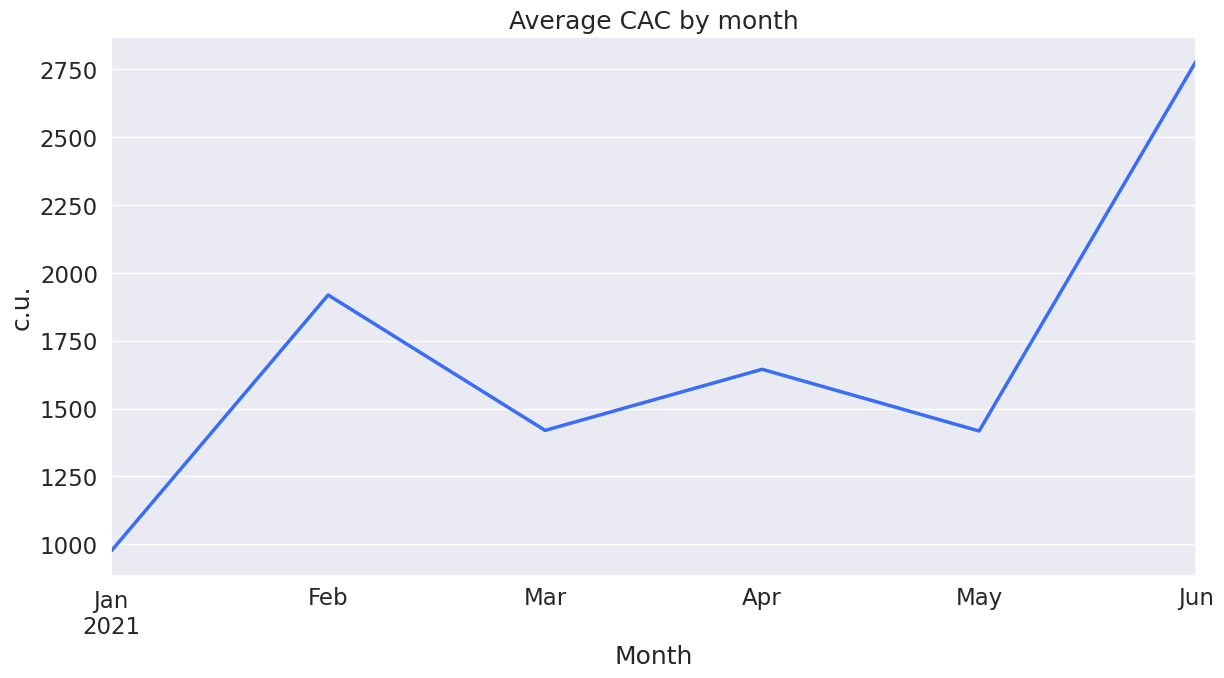

In [ ]:
#CAC by month
CAC_by_month = pd.merge(costs_data.groupby('costs_month').agg({'cost': 'sum'}),
                        first_orders_data.groupby('first_purchase_month').agg({'user_id': 'nunique'}),
                        left_index=True,
                        right_index=True)

CAC_by_month['cac'] = CAC_by_month['cost']  / CAC_by_month['user_id']

CAC_by_month['cac'].plot(figsize=(14,7), title='Average CAC by month', xlabel = 'Month', ylabel = 'c.u.');

In [ ]:
user_source = visits_data[['user_id', 'source']].drop_duplicates()

In [ ]:
first_orders_data = pd.merge(first_orders_data, user_source, on = 'user_id')

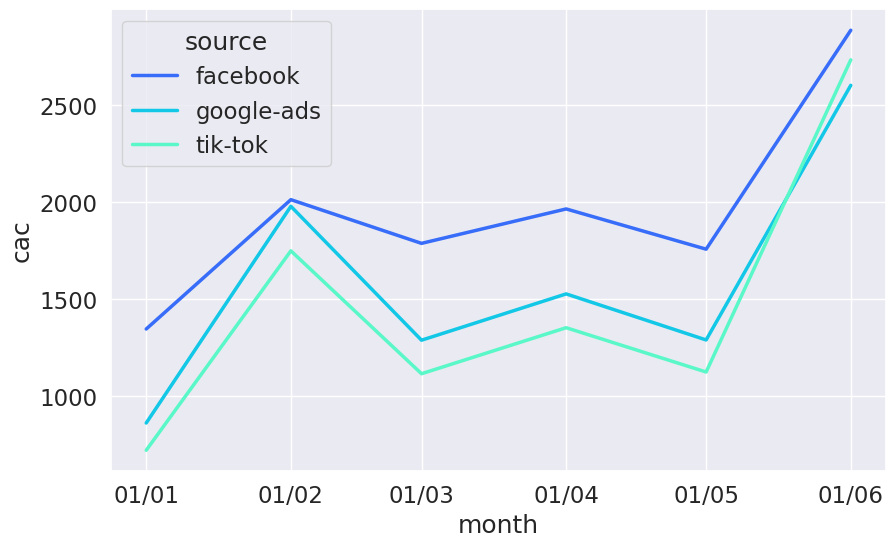

In [ ]:
#CAC by month
CAC_by_month = pd.merge(costs_data.groupby(['costs_month', 'source']).agg({'cost': 'sum'}).reset_index().rename(columns = {'costs_month' : 'month'}),
                        first_orders_data.groupby(['first_purchase_month', 'source']).agg({'user_id': 'nunique'}).reset_index().rename(columns = {'first_purchase_month' : 'month'}),
                        on = ['month', 'source'])

CAC_by_month['cac'] = CAC_by_month['cost']  / CAC_by_month['user_id']
CAC_by_month['month'] = CAC_by_month['month'].dt.to_timestamp()

fig, ax = plt.subplots(figsize = (10,6))
sns.lineplot(x = 'month', y = 'cac', hue = 'source', data = CAC_by_month);

locator = mdates.AutoDateLocator(interval_multiples=True)
formatter = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

#### ROI (Return on Invesments)


Many ways to calculate it:

$$\frac{\text{Total Gains}}{\text{Total Costs}}$$

In our case, we can define the ROMI (Return on Marketing Investments) as:

$$\frac{\text{LTV}}{\text{CAC}}$$


In [ ]:
month_revenue = orders_data.groupby(['user_id', 'month']).agg({'sale': 'sum'}).reset_index()
buyers = first_orders_data.merge(month_revenue,on = 'user_id')

In [ ]:
buyers

,user_id,first_purchase,first_purchase_month,source,month,sale
0,0,2021-02-01 00:40:40,2021-02,facebook,2021-02,345.01
1,3,2021-01-29 05:19:12,2021-01,facebook,2021-01,300.93
2,3,2021-01-29 05:19:12,2021-01,facebook,2021-02,740.17
3,4,2021-01-28 19:31:08,2021-01,facebook,2021-01,316.85
4,5,2021-01-27 10:24:01,2021-01,tik-tok,2021-01,304.31
...,...,...,...,...,...,...
6184,4997,2021-05-26 06:26:59,2021-05,facebook,2021-05,340.78
6185,4997,2021-05-26 06:26:59,2021-05,facebook,2021-06,981.34
6186,4998,2021-04-30 21:07:26,2021-04,tik-tok,2021-04,301.89
6187,4998,2021-04-30 21:07:26,2021-04,tik-tok,2021-05,348.83


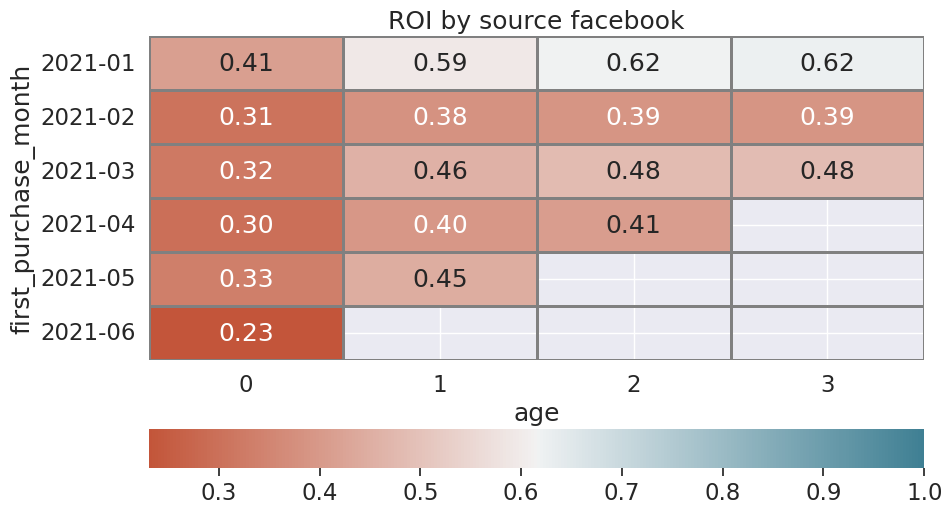

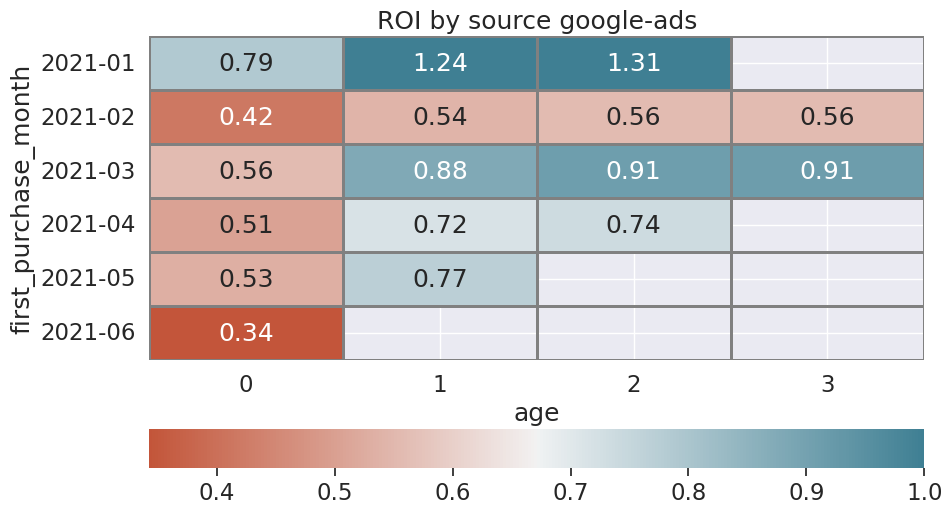

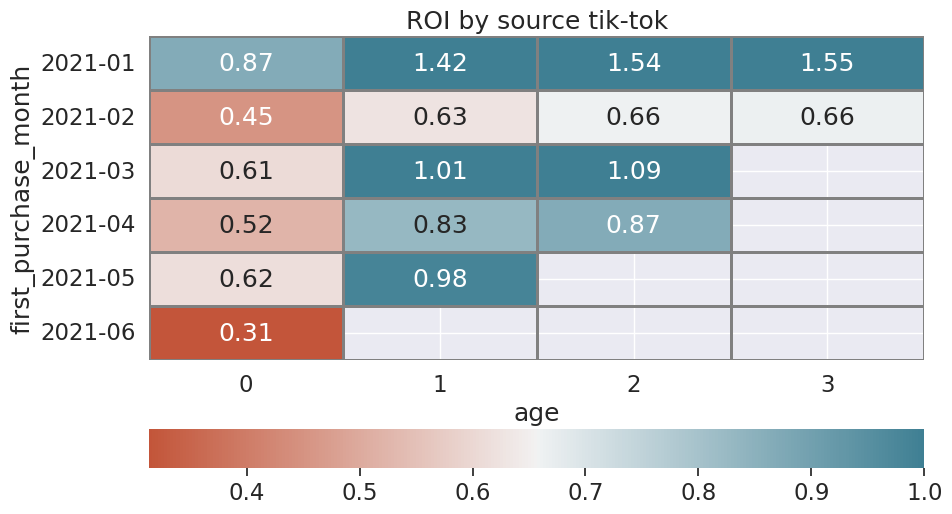

In [ ]:
for source, df in buyers.groupby('source'):
      cohort_sizes_t = (
          df.groupby(['source', 'first_purchase_month'])
          .agg({'user_id': 'nunique'})
          .reset_index()
      )
      cohort_sizes_t.columns = ['source', 'first_purchase_month', 'n_buyers']

      cohorts_revenue_t = (
          df.groupby(['source', 'first_purchase_month', 'month'])
          .agg({'sale': 'sum'})
          .reset_index()
      )
      cohorts_revenue_t.columns = ['source', 'first_purchase_month', 'order_month', 'gp']

      report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source', 'first_purchase_month'])
      report_romi['age'] = (report_romi['order_month'].astype(int) - report_romi['first_purchase_month'].astype(int))
      report_romi['age'] = report_romi['age'].round().astype('int')
      report_romi['ltv'] = report_romi['gp'] / report_romi['n_buyers']

      report_romi = pd.merge(report_romi,costs_data.groupby(['source', 'costs_month']).agg({'cost': 'sum'}).reset_index(),
                      left_on=['source', 'first_purchase_month'], right_on=['source', 'costs_month'])
      report_romi = report_romi.drop(['costs_month'], axis = 1)
      report_romi['cac'] = report_romi['cost'] / report_romi['n_buyers']
      report_romi['romi'] = report_romi['ltv'] / report_romi['cac']


      romi = report_romi\
              .pivot_table(index='first_purchase_month', columns='age', values='romi', aggfunc='mean')\
              .cumsum(axis=1)
      romi.round(2).fillna('')


      romi.index=romi.index.astype(str)
      fig, ax = plt.subplots(figsize = (10, 6))
      sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='grey',  cmap=sns.diverging_palette(20, 220, as_cmap=True), vmax = 1, cbar_kws= {'orientation': 'horizontal'}
          ).set(title ='ROI by source {}'.format(source))
      plt.show()


